In [1]:
%matplotlib inline

import gym
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import numpy as np
import sys
from collections import defaultdict, OrderedDict

from randomwalk import RandomWalk
from mdp import reset,policy_eval

In [2]:
# env = BlackjackEnv()
# env = gym.make('Taxi-v2').unwrapped
# numA = env.action_space.n
# numS = env.observation_space.n
env = RandomWalk()
numS = 7
numA = 2
np.random.seed(3)
print("#state:{}, #action{}".format(numS, numA))

#state:7, #action2


In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def plot_value_function(V, baseline, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    fig = plt.figure()
    fig, (ax1, ax2) = plt.subplots(1,2)
    V_ordered = OrderedDict(sorted(V.items()))
    
    print('\n')
    print(len(V.keys()))
    
    v_s = np.zeros(len(V.keys()))
    idx = 0
    for key, val in V_ordered.items():
        v_s[idx] = val
        idx +=1

    ax1.plot(v_s,marker='o',linestyle='None',label='mc')
    ax1.plot(baseline,marker='x',linestyle='None',label='base')
    ax1.legend(["MC", "Baseline"])
    ax1.set_title(title)
    ax1.set_xlabel("State", fontsize=20)
    
    ax2.plot(v_s,marker='o',linestyle='None',label='mc')
    ax2.plot(baseline[1:-1],marker='x',linestyle='None',label='base')
    ax2.legend(["MC", "Baseline"])
    ax2.set_title('MC trimed baseline')
    ax2.set_xlabel("State", fontsize=20)
    plt.savefig("mc_randomwalk.png")

In [5]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
#         for t in range(1000):
        done=False
        while not done:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)

            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([x[0] for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V    



5


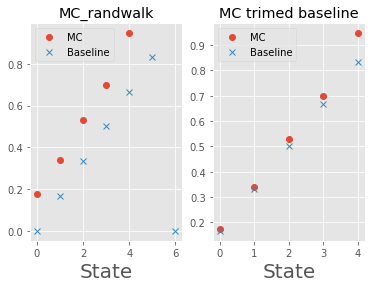

In [6]:
policy = create_random_policy(numA)
baseline = np.arange(7) / 6
baseline[-1] = 0   
V_10k = mc_prediction(policy, env, num_episodes=1000)
plot_value_function(V_10k, baseline, title="MC_randwalk")
